<a href="https://colab.research.google.com/github/camerontruong/ARA-READABILITY/blob/main/fWHR_V2_22OCT21.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [ ]:
!pip install dlib
import dlib

In [ ]:
!pip install face_recognition
import math

from matplotlib.pyplot import imshow
from PIL import Image, ImageDraw
import face_recognition
import urllib.request

     |████████████████████████████████| 100.1 MB 22 kB/s 
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566185 sha256=94d104a6b75de58e059ef0df2443603c449dacd3894966e9acd82e7e48af44b9
  Stored in directory: /root/.cache/pip/wheels/d6/81/3c/884bcd5e1c120ff548d57c2ecc9ebf3281c9a6f7c0e7e7947a
Successfully built face-recognition-models


In [ ]:
def load_image(path, url=False):
    if not url:
        return face_recognition.load_image_file(path)
    else:
        if path[-3:] == 'jpg' or  path[-3:] == 'peg':
            urllib.request.urlretrieve(path, 'tmp.jpg')
            return face_recognition.load_image_file('tmp.jpg')
        elif path[-3:] == 'png':
            urllib.request.urlretrieve(path, 'tmp.png')
            return face_recognition.load_image_file('tmp.png')
        else:
            print("Unknown image type")

In [ ]:
def get_face_points(points, method='average', top='eyebrow'):
    width_left, width_right = points[0], points[16]
    
    if top == 'eyebrow':
        top_left = points[18]
        top_right = points[25]
        
    elif top == 'eyelid':
        top_left = points[37]
        top_right = points[43] 
        
    else:
        raise ValueError('Invalid top point, use either "eyebrow" or "eyelid"')
        
    bottom_left, bottom_right = points[50], points[52]
    
    if method == 'left':
        coords = (width_left[0], width_right[0], top_left[1], bottom_left[1])
        
    elif method == 'right':
        coords = (width_left[0], width_right[0], top_right[1], bottom_right[1])
        
    else:
        top_average = int((top_left[1] + top_right[1]) / 2)
        bottom_average = int((bottom_left[1] + bottom_right[1]) / 2)
        coords = (width_left[0], width_right[0], top_average, bottom_average)
        
    ## Move the line just a little above the top of the eye to the eyelid    
    if top == 'eyelid':
        coords = (coords[0], coords[1], coords[2] - 4, coords[3])
        
    return {'top_left' : (coords[0], coords[2]),
            'bottom_left' : (coords[0], coords[3]),
            'top_right' : (coords[1], coords[2]),
            'bottom_right' : (coords[1], coords[3])
           }

In [ ]:
def good_picture_check(p, debug=False):
    ## To scale for picture size
    width_im = (p[16][0] - p[0][0]) / 100
    
    ## Difference in height between eyes
    eye_y_l = (p[37][1] + p[41][1]) / 2.0
    eye_y_r = (p[44][1] + p[46][1]) / 2.0
    eye_dif = (eye_y_r - eye_y_l) / width_im
    
    ## Difference top / bottom point nose 
    nose_dif = (p[30][0] - p[27][0]) / width_im
    
    ## Space between face-edge to eye, left vs. right
    left_space = p[36][0] - p[0][0]
    right_space = p[16][0] - p[45][0]
    space_ratio = left_space / right_space
    
    if debug:
        print(eye_dif, nose_dif, space_ratio)
    
    ## These rules are not perfect, determined by trying a bunch of "bad" pictures
    if eye_dif > 5 or nose_dif > 3.5 or space_ratio > 3:
        return False
    else:
        return True

In [ ]:
def FWHR_calc(corners):
    width = corners['top_right'][0] - corners['top_left'][0]
    height = corners['bottom_left'][1] - corners['top_left'][1]
    return round(float(width) / float(height),4)

In [ ]:
def show_box(image, corners):
    pil_image = Image.fromarray(image)
    w, h = pil_image.size
    
    ## Automatically determine width of the line depending on size of picture
    line_width = math.ceil(h / 100)
    
    d = ImageDraw.Draw(pil_image) 
    d.line([corners['bottom_left'], corners['top_left']], width = line_width)
    d.line([corners['bottom_left'], corners['bottom_right']], width = line_width)
    d.line([corners['top_left'], corners['top_right']], width = line_width)
    d.line([corners['top_right'], corners['bottom_right']], width = line_width)
    
    imshow(pil_image)

In [ ]:
def get_fwhr(image_path, url=False, show=True, method='average', top='eyelid'):
    image = load_image(image_path, url)
    landmarks = face_recognition.api._raw_face_landmarks(image)
    landmarks_as_tuples = [(p.x, p.y) for p in landmarks[0].parts()]
    
    if good_picture_check(landmarks_as_tuples): 
        corners = get_face_points(landmarks_as_tuples, method=method, top = top)
        fwh_ratio = FWHR_calc(corners)
        
        if show:
            print('The Facial-Width-Height ratio is: {}'.format(fwh_ratio))
            show_box(image, corners)
        else:
            return fwh_ratio
    # else:
    #     if show:
    #         print("Picture is not suitable to calculate fwhr.")
    #         imshow(image)
    #     else:
    #         return None

The Facial-Width-Height ratio is: 1.9138


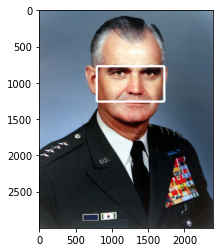

In [ ]:
westmoreland_url ="https://upload.wikimedia.org/wikipedia/commons/9/94/Gen_William_C_Westmoreland.jpg"
get_fwhr(westmoreland_url, url=True, top = 'eyebrow')

The Facial-Width-Height ratio is: 2.125


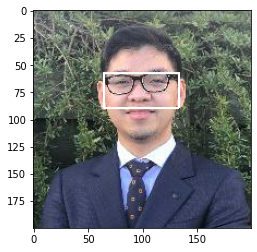

In [ ]:
harvey_url="https://www.massey.ac.nz/massey/fms/expertise/user_images/profile_054796_08A3D7EF-2BB8-48A6-82B0618619F5580B.jpg"
get_fwhr(harvey_url, url=True, top = 'eyebrow')

The Facial-Width-Height ratio is: 1.9434


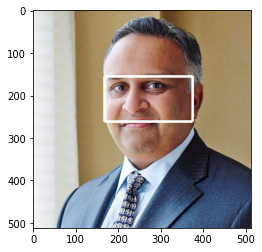

In [ ]:
bhasin_url="https://content.onlinexperiences.com/FileLibrary/4472/6/aditya_bhasin.jpg"
get_fwhr(bhasin_url, url=True, top = 'eyebrow')

In [ ]:
musk_url="https://e3.365dm.com/21/02/2048x1152/skynews-elon-musk_5257586.jpg"
get_fwhr(musk_url, url=True, top = 'eyebrow')

The Facial-Width-Height ratio is: 2.0


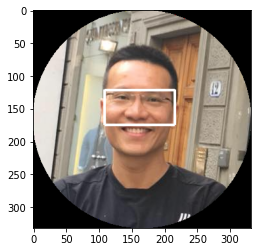

In [ ]:
camtruong_url ="/content/CTcircle-cropped.png"
get_fwhr(camtruong_url, url=False, top = 'eyebrow')

The Facial-Width-Height ratio is: 1.4734


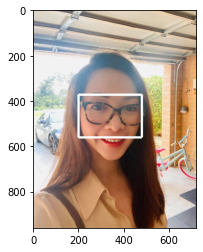

In [ ]:
amypham_url ="/content/amy.jpg"
get_fwhr(amypham_url, url=False, top = 'eyebrow')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import glob
import os

Mounted at /content/drive


In [ ]:
from IPython.display import Image as ImageShow
ImageShow(url = 'https://cdn-images-1.medium.com/max/1600/1*AbEg31EgkbXSQehuNJBlWg.png')

In [ ]:
folders = {"f1":'/content/drive/MyDrive/Images of audit partners (1 to 500)/',
           "f2":'/content/drive/MyDrive/Images of audit partner (501 to 1000)/',
           "f3":'/content/drive/MyDrive/Images of audit partner (1001 to 1500)/',
           "f4":'/content/drive/MyDrive/Image of Audit partner (1500-2000)/',
           "f5":'/content/drive/MyDrive/Images of audit partner (2000 to 2500)/',
           "f6":'/content/drive/MyDrive/Images of audit partners (2501 to 3000)/',
           "f7":'/content/drive/MyDrive/Images of audit partner (3001 to 3500)/',
           "f8":'/content/drive/MyDrive/Images of audit partners (3501 to 4000)/',
           "f9":'/content/drive/MyDrive/Images of audit partners (4001 to 4500)/',
           "f10":'/content/drive/MyDrive/Images of audit partner (4501 to 4999)/',
           "f11":'/content/drive/MyDrive/Images of Audit Partners(5000-5500)/',
           "f12":'/content/drive/MyDrive/Image of Audit partner (5501 to 6000)/',
           "f13":'/content/drive/MyDrive/Images of audit partner (6001 - 6420)/'
}

In [ ]:
METHOD = 'average'
TOP = 'eyebrow'
data = {}
for k,v in folders.items():
    TARGET_FILES = f'{v}*.jpg'
    file_list = glob.glob(TARGET_FILES)
    print(k, len(file_list))
    for i,file in enumerate(file_list):
        print(file+' '+str(i+1))
        n=(file.split('.jpg')[0]).split(v)[-1]
        image = load_image(file)
        landmarks = face_recognition.api._raw_face_landmarks(image)
        try:
            landmarks_as_tuples = [(p.x, p.y) for p in landmarks[0].parts()]
            corners = get_face_points(landmarks_as_tuples, method=METHOD, top = TOP)
            fwh_ratio = FWHR_calc(corners)
            print(fwh_ratio)
            data[n]=fwh_ratio

        except:
            print("XuBALA")



Streaming output truncated to the last 5000 lines.
/content/drive/MyDrive/Images of audit partner (2000 to 2500)/18500078.jpg 47
1.8194
/content/drive/MyDrive/Images of audit partner (2000 to 2500)/18500081.jpg 48
1.5789
/content/drive/MyDrive/Images of audit partner (2000 to 2500)/18500083.jpg 49
2.042
/content/drive/MyDrive/Images of audit partner (2000 to 2500)/18500084.jpg 50
2.0145
/content/drive/MyDrive/Images of audit partner (2000 to 2500)/18500085.jpg 51
1.9344
/content/drive/MyDrive/Images of audit partner (2000 to 2500)/18500086.jpg 52
2.0588
/content/drive/MyDrive/Images of audit partner (2000 to 2500)/18500087.jpg 53
1.7342
/content/drive/MyDrive/Images of audit partner (2000 to 2500)/18500088.jpg 54
1.8562
/content/drive/MyDrive/Images of audit partner (2000 to 2500)/18500089.jpg 55
1.7342
/content/drive/MyDrive/Images of audit partner (2000 to 2500)/18500090.jpg 56
1.7118
/content/drive/MyDrive/Images of audit partner (2000 to 2500)/18500091.jpg 57
1.9315
/content/drive/

In [ ]:
print(data)

{'2300004': 1.9, '2300005': 1.9545, '2300010': 1.8, '2300015': 2.0909, '2300051': 1.9286, '2300018': 1.8205, '2300019': 1.7705, '2300020': 2.0278, '2300021': 1.8636, '2300022': 1.8276, '2300023': 1.8, '2300030': 2.0, '2300031': 1.8108, '2300032': 1.963, '2300035': 1.9362, '2300037': 1.7667, '2300044': 1.8298, '2300045': 1.8605, '2300052': 2.027, '2300053': 1.7273, '2300057': 1.931, '2300059': 2.0, '2300070': 2.1622, '2300079': 1.7222, '2701010': 1.775, '2900002': 1.8529, '2900003': 1.814, '3200003': 1.8889, '3200004': 1.7317, '3410529': 1.8333, '3410531': 1.7458, '3410542': 1.9048, '3410543': 1.881, '3410547': 1.8824, '3410548': 2.0769, '3410549': 1.8049, '3410556': 1.8222, '3410558': 2.1875, '3410576': 1.5957, '3410580': 1.9412, '3410581': 1.8077, '3410584': 1.5, '3410592': 2.0, '3410596': 2.0, '3410609': 1.7838, '3410615': 1.7708, '3410616': 1.7333, '3410619': 2.02, '3410623': 1.766, '3410625': 1.8125, '3410645': 1.8974, '3410652': 1.9583, '3410653': 1.8438, '3410654': 1.8788, '34106

In [ ]:
name =[]
ratio = []
for k,v in data.items():
    name.append(k)
    ratio.append(v)

dict = {"id":name,
        "fWHR":ratio
        }
import pandas as pd
df = pd.DataFrame(dict)
df 

In [ ]:
df["fWHR"].mean()

1.8562459756097516

In [ ]:
df["fWHR"].std()

0.14560346896942752

In [ ]:
df["fWHR"].min()

In [ ]:
df.to_csv(f'/content/drive/My Drive/VNMILK/EYEBROW_FWHR.csv')